In [9]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
import seaborn as sns
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12
from tqdm import tqdm, tqdm_notebook
from scipy import stats
import itertools as it

import glob
import os

<img src="./../images/kitten.jpg" align="right" width="320" />
Здравствуйте, коллеги. Рассмотрим обычный онлайн эксперимент в некоторой компании "Усы и когти". У них есть веб сайт, на котором есть красная кнопка, в форме прямоугольника с закругленными краями. Если пользователь нажимает на эту кнопку, то где то в мире мурлычет от радости один котенок. Задача компании максимизация мырлыкания. Так же есть отдел маркетинга, который усердно исследует формы кнопок и то, как они влияют на конверсию показов в клико-мурлыкания. Потратив почти весь бюджет компании на уникальные исследования, маркетинг разделился на четыре противоборствующие группировоки. У каждой группировки есть своя гениальная идея того, как должна выглядеть кнопка. В целом никто не против формы кнопки, но красный раздражает всех маркетологов, и было предложенно четыре альтернативных варианта. На самом деле не так важно даже какие варианты, нас интересует тот вариант, который максимизирует мырлыкания. Маркетинг предлагает провести A/B/n тест, но мы не согласны, и так на эти сомнительные исследования спущено денег немеренно. Попробуем осчастливить как можно больше котят и сэкономить на трафике. Для оптимизации трафика, пущенного на тесты, мы будет использовать шайку многоруких байесовских бандитов (bayesian multi-armed bandits). Вперед.

# A/B/n тест

Будем считать, что клик - это некоторая случайная переменная $k$, принимающая значения  $0$ или $1$, с вероятностью $\theta$ и $1 - \theta$ соответственно. Такая величина имеет распределение Бернулли с параметром $\theta$:

$$\large 
\begin{array}{rcl}
k &\sim& \text{Bernoulli}\left(\theta\right) \\
p\left(k = 1\right) &=& \theta^k \left(1 - \theta\right)^{1 - k}
\end{array}
$$

Вспомним, что среднее значение распределения Бернулли равно $\mu = \theta$, а дисперсия равна $\sigma^2 = \theta\left(1 - \theta\right)$.

Попробуем для начала решить проблему с помощью обычного A/B/n теста, n здесь означает, что тестируются не две гипотезы, а несколько. В нашем случае это пять гипотез. Но мы рассмотрим сначала ситуацию тестирования старого решения против нового, а затем обобщим на все пять случаев. В бинарном случае у нас есть две гипотезы:
- нулевая гипотеза $H_0: \theta_c = \theta_t$ заключается в том, что нет никакой разницы в вероятностью клика по старой кнопке $\theta_c$ и или по новой $\theta_t$;
- альтернативная гипотеза $H_1: \theta_c < \theta_t$ заключается в том, что вероятностью клика по старой кнопке $\theta_c$ меньше чем по новой $\theta_t$;
- вероятности $\theta_c$ и $\theta_t$ мы оцениваем как отношение кликов к показам на контролькой группе (control) и экспериментальной/тестовой группе (treatment) соответственно.

Мы не можем знать истинное значение конверсии $\theta_c$ на текущей вариации кнопки (на красной), но мы можем его оценить. Для этого у нас есть два механизма, которые работаю сообща. Во-первых, <a href="https://ru.wikipedia.org/wiki/Закон_больших_чисел">закон больших чисел</a>, который утверждает, что какое бы не было распределение случайной величины, если мы посемплируем достаточное количество примеров и усредним, то такая оценка будет близка к истинному значению среднеднего значения распределения (опустим пока индекс $c$ для ясности):

$$\large
\begin{array}{rcl}
\overline{\theta}_n &=& \frac{1}{n}\sum_{i=1}^n k_i \\
\forall \epsilon \in \mathbb{R}: \lim_{n \rightarrow \infty} &=& P\left(\left|\overline{\theta}_n - \mu\right| < \epsilon\right) = 1
\end{array}
$$

Во-вторых, <a href="https://ru.wikipedia.org/wiki/Центральная_предельная_теорема">центральная предельная теорема</a>, которая утверждает следующее. Допустим есть бесконечный ряд независимых и одинаково распределенных случайных величин $k_1, k_2, \ldots$, с истинным матожиданием $\mu$ и дисперсией $\sigma^2$. Обозначим конечную сумму как $S_n = \sum_{i}^n k_i$, тогда

$$\large
\frac{S_n - \mu}{\sigma\sqrt{n}} \rightarrow \mathcal{N}\left(0, 1\right)\text{ при }n \rightarrow \infty
$$

или эквивалентно, тому, что при достаточно больших выборках оценка среднего значения имеет нормальное распределение с центром в $\mu$ и дисперсией $\frac{\sigma^2}{n}$:

$$\large
\overline{\theta} \sim \mathcal{N}\left(\mu, \frac{\sigma^2}{n}\right)
$$

Казалось бы бери да запускай два теста: раздели трафик на две части, жди пару дней, и сравнивай средние значения кликов по первому механизму. Второй механизм позволяет нам применять <a href="https://ru.wikipedia.org/wiki/T-Критерий_Стьюдента">t-тест</a> для оценки статистической значимости разницы средних значений выборок (потому что оценки средних имеют нормальное распределение). А так же, увеличивая размер выборки $n$, мы уменьшаем дисперсию оценки среднего, тем самым увеличивая свою уверенность. Но остается один важный вопрос: а какое количество трафика (пользователей) пустить на каждуй вариацию кнопки. Статистика нам говорит, что если разница не нулевая, то это еще совсем не значит, что значения не равны. Возможно не повезло просто и первые $70\%$ пользователей люто ненавидели какой то цвет, и нужно подождать еще. И возникает вопрос, а сколько пользователей пустить на каждую вариацию кнопки, что бы быть уверенным, что если разница и есть, то она существенная. Для этого нам придется еще раз встретиться с отделом маркетинга, и задать им несколько вопросов, и вероятно нам придется им объяснить, что такое ошибки первого и второго рода. В общем это может быть чуть ли не самым сложным во всем тесте. Итак, вспомним, что это за ошибки, и определим вопросы, которые следует задать отделу маркетинга, что бы оценить количество трафика на вариацию. В конечном счете именно маркетинг принимает окончательно решение о том, какой цвет кнопки оставить. 

<table>
<tr><td colspan=2 rowspan=2></td><td colspan=2>Верная гипотеза</td></tr>
<tr><td>$H_0$</td><td>$H_1$</td></tr>
<tr>
    <td rowspan=2>Ответ теста</td>
    <td>$H_0$</td>
    <td bgcolor="lightgreen">$H_0$ принята</td>
    <td bgcolor="LightCoral">$H_0$ неверно принята <br/> (ошибка II рода)</td>
</tr>
<tr>
    <td>$H_1$</td>
    <td bgcolor="LightCoral">$H_0$ неверно отвергнута <br/> (ошибка I рода)</td>
    <td bgcolor="lightgreen">$H_0$ отвергнута</td>
</tr>
</table>

Введем еще несколько понятий. Обозначим вероятность ошибки первого рода как $\alpha = P\left(H_1 \mid H_0\right)$, т.е. вероятность принятия альтернативной гипотезы, при условии, что на самом деле верна нулевая гипотеза. Эта величина называется статистической значимостью (statistical significance). Так же нам понадобидся ввести вероятность ошибки второго рода $\beta = P\left(H_0 \mid H_1\right)$. Величина $1 - \beta$ называется статистической мощностью (statistical power). 

Рассмотрим изображени ниже, что бы проиллюстрировать смысл статистической значимости и мощности. Предположим, что среднее значение распределения случайной величины на контрольной группе равно $\mu_c$, а на тестовой $\mu_t$. Выберем некоторый критический порог выше которого гипотеза $H_0$ отвергается (вертикальная зеленая линия). Тогда, если значение было правее порога, но из распределения контрольной группы, то мы его ошибочно припишем к распределению тестовой группы. Это будет ошибка первого рода, а значение $\alpha$ это прощадь закрашенная красным цветом. Соответственно, область закрашенная синим цветом равна $\beta$. Величина $1 - \beta$, которую мы назвали статистической мощностью, по сути это то, сколько значений соответствующих альтернативной гипотезе мы действительно отнесем к альтернативной гипотезе.

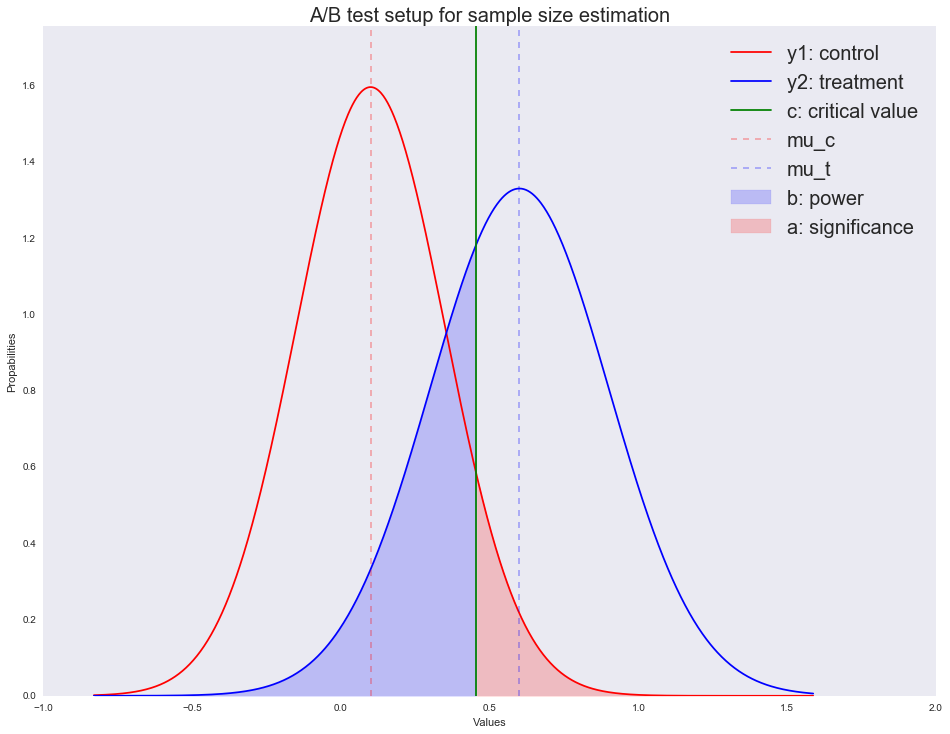

In [10]:
# средние значение двух распределений
mu_c = 0.1
mu_t = 0.6

# дисперсии двух распределений
s_c = 0.25
s_t = 0.3

# порог, наблюдая значение исследуемой величины выше этого порога,
# мы относим ее к синему распределению
c = 1.3*(mu_c + mu_t)/2

support = np.linspace(
    stats.norm.ppf(0.0001, loc=mu_c, scale=s_c), 
    stats.norm.ppf(1 - 0.0005, loc=mu_t, scale=s_t), 1000)
y1 = stats.norm.pdf(support, loc=mu_c, scale=s_c)
y2 = stats.norm.pdf(support, loc=mu_t, scale=s_t)

fig, ax = plt.subplots()
ax.plot(support, y1, color='r', label='y1: control')
ax.plot(support, y2, color='b', label='y2: treatment')
ax.set_ylim(0, 1.1*np.max([
            stats.norm.pdf(mu_c, loc=mu_c, scale=s_c),
            stats.norm.pdf(mu_t, loc=mu_t, scale=s_t)
        ]))
ax.axvline(c, color='g', label='c: critical value')
ax.axvline(mu_c, color='r', alpha=0.3, linestyle='--', label='mu_c')
ax.axvline(mu_t, color='b', alpha=0.3, linestyle='--', label='mu_t')
ax.fill_between(support[support <= c], 
                y2[support <= c], 
                color='b', alpha=0.2, label='b: power')
ax.fill_between(support[support >= c], 
                y1[support >= c], 
                color='r', alpha=0.2, label='a: significance')

ax.legend(loc='upper right', prop={'size': 20})
ax.set_title('A/B test setup for sample size estimation', fontsize=20)
ax.set_xlabel('Values')
ax.set_ylabel('Propabilities')

plt.show()

Обозначим этот порог буквой $c$, то справедливо следующее равенствно, при условии, что случайная величина имеет нормальное распределение:

$$\large
c = \mu + t\frac{\sigma}{\sqrt{n}}
$$
где $t = P\left(X \leq t\right), X \sim \mathcal{N}\left(0, 1\right)$ - это <a href="https://ru.wikipedia.org/wiki/Функция_ошибок">квантильная функция</a>.

В нашем случае мы можем записать систему из двух уравнений для $\alpha$ и $\beta$ соответственно:

$$\large
\begin{array}{rcl}
c &=& \theta_c + t_{\alpha}\sqrt{\frac{\theta_c\left(1 - \theta_c\right)}{n}} \\
c &=& \theta_t + t_{\beta}\sqrt{\frac{\theta_t\left(1 - \theta_t\right)}{n}}
\end{array}
$$

Решив эту систему относительно $n$ мы получим оценку достаточного количества трафика, который необходимо загнать в каждый эксперимент при заданной статистической значимости и мощности. 

$$\large
\begin{array}{rcl}
\theta_c + t_{\alpha}\sqrt{\frac{\theta_c\left(1 - \theta_c\right)}{n}} &=& \theta_t + t_{\beta}\sqrt{\frac{\theta_t\left(1 - \theta_t\right)}{n}} \\
\theta_c \sqrt{n} + t_{\alpha}\sqrt{\theta_c\left(1 - \theta_c\right)} &=& \theta_t \sqrt{n} + t_{\beta}\sqrt{\theta_t\left(1 - \theta_t\right)} \\
n &=& \left(\frac{t_{\beta}\sqrt{\theta_t\left(1 - \theta_t\right)} - t_{\alpha}\sqrt{\theta_c\left(1 - \theta_c\right)}}{\theta_c - \theta_t}\right)^2
\end{array}
$$


Например, если реальное значение конверсии $0.001$, а новое $0.0011$, тогда при $\alpha = \beta = 0.01$ нам необходимо прогнать **2 269 319** пользователей через каждую вариацию. А новая вариация будет принята в случае если ее конверсия привысит $0.00104$.

In [3]:
def get_size(theta_c, theta_t, alpha, beta):
    t_alpha = stats.norm.ppf(1 - alpha, loc=0, scale=1)
    t_beta = stats.norm.ppf(beta, loc=0, scale=1)
    n = t_alpha*np.sqrt(theta_t*(1 - theta_t))
    n -= t_beta*np.sqrt(theta_c*(1 - theta_c))
    n /= theta_c - theta_t
    return int(np.ceil(n*n))

n_max = get_size(0.001, 0.0011, 0.01, 0.01)
print n_max
print 0.001 + stats.norm.ppf(1 - 0.01, loc=0, scale=1)*np.sqrt(0.001*(1 - 0.001)/n_max)

2269319
0.00104881009215


Таким образом, что бы вычислить эффективный размер выборки, мы должны пойти в маркетинг или другой бизнес департамент и узнать у них следующее:
- какое значение конверсии $\theta_t$ на новой вариации должно получиться, что бы бизнес принял решение перейти со старой версии кнопки с конверсией $\theta_c$ на новую;
- какой допустимый уровень значимости $\alpha$ и мощности $\beta$ необходим (вероятно тут еще придется как то объяснить бизнесу что это значит).

Получив $n$ мы можем легко вычислить порог $c$. Это значит, что если мы соберем $n$ наблюдейний для каждой вариации, и окажется, что в экспериментальной группе оценка клика $\theta_t$ выше порога $c$, то мы отклняем $H_0$ и принимаем альтернативную гипотезу $H_1$, о том что новая вариация лучше и вероятно мы ее внедрим. В этом случае у нас будет $\alpha \cdot 100\%$ шансов ошибки первого рода, т.е. мы ошибочно приняли решение заменить старую кнопку на новую. И $\left(1 - \beta\right)\cdot 100\%$ шансов, что если новая вариация лучше, то мы правильно и сделали, что ее внедрили. Но самое печальное в том, что если после эксперимента, когда мы прогнали трафик через две вариации, окажется, что $\theta_t < c$, то мы считаем, что нет оснований отказываться от старой кнопки. Именно нет основания, мы не доказали, что новая кнопка хуже, мы как были в неопределенности, так и остались. Такие дела.

Честно говоря, мне кажется что выводы полученные в предыдущем абзаце не очень убедительны, и вообще могут запутать не только вас. Представьте, отдел маркетинга потратил пару миллионов рублей на уникальные исследования новой формы кнопки, а вы им такой "нет оснований считать что она лучше". Кстати на счет оснований, давайте проиллюстрируем как решается уравнение относительно размера выборки, и как изменяются распределение оценки среднего значения при увеличении размера выборки. На анимации вы можете наблюдать, как при увеличении размера выборки, размах распределения оценки среднего уменьшается, т.е. уменьшается дисперсия оценки, которая и отождествляется с нашей уверенностью в этой оценки. На самом деле изображение ниже немного нечестное, при уменьшении размаха распределения, оно еще и увеличивается в высоту, т.к. площадь должна оставаться постоянной. Реальная анимация в спойлере, но она чуть менее очевидна. 

In [11]:
np.random.seed(1342)

p_c = 0.3 
p_t = 0.4
alpha = 0.05
beta = 0.2

n_max = get_size(p_c, p_t, alpha, beta)
c = p_c + stats.norm.ppf(1 - alpha, loc=0, scale=1)*np.sqrt(p_c*(1 - p_c)/n_max)
print n_max, c


def plot_sample_size_frames(do_dorm, width, height):
    left_x = c - width
    right_x = c + width
    
    n_list = range(5, n_max, 1) + [n_max]
    for f in glob.glob("./../images/sample_size_gif/*_%s.*" % 
                       ('normed' if do_dorm else 'real')):
        os.remove(f)
    for n in tqdm_notebook(n_list):
        s_c = np.sqrt(p_c*(1 - p_c)/n)
        s_t = np.sqrt(p_t*(1 - p_t)/n)

        c_c = p_c + stats.norm.ppf(1 - alpha, loc=0, scale=1)*s_c
        c_t = p_t + stats.norm.ppf(beta, loc=0, scale=1)*s_t

        support = np.linspace(left_x, right_x, 1000)
        y_c = stats.norm.pdf(support, loc=p_c, scale=s_c)
        y_t = stats.norm.pdf(support, loc=p_t, scale=s_t)
        if do_dorm:
            y_c /= max(y_c.max(), y_t.max())
            y_t /= max(y_c.max(), y_t.max())


        fig, ax = plt.subplots()
        ax.plot(support, y_c, color='r', label='y control')
        ax.plot(support, y_t, color='b', label='y treatment')

        ax.set_ylim(0, height)
        ax.set_xlim(left_x, right_x)

        ax.axvline(c, color='g', label='c')
        ax.axvline(c_c, color='m', label='c_c')
        ax.axvline(c_t, color='c', label='c_p')
        ax.axvline(p_c, color='r', alpha=0.3, linestyle='--', label='p_c')
        ax.axvline(p_t, color='b', alpha=0.3, linestyle='--', label='p_t')

        ax.fill_between(support[support <= c_t], 
                        y_t[support <= c_t], 
                        color='b', alpha=0.2, label='b: power')
        ax.fill_between(support[support >= c_c], 
                        y_c[support >= c_c], 
                        color='r', alpha=0.2, label='a: significance')

        ax.legend(loc='upper right', prop={'size': 20})

        ax.set_title('Sample size: %i' % n, fontsize=20)

        fig.savefig('./../images/sample_size_gif/%i_%s.png' % 
                    (n, 'normed' if do_dorm else 'real'), dpi=80)

        plt.close(fig)
        
        
plot_sample_size_frames(do_dorm=True, width=0.5, height=1.1)
plot_sample_size_frames(do_dorm = False, width=1, height=2.5)

142 0.363254690043




In [12]:
!convert -delay 5 $(for i in $(seq 5 1 142); do echo ./../images/sample_size_gif/${i}_normed.png; done) -loop 0 ./../images/sample_size_gif/sample_size_normed.gif
for f in glob.glob("./../images/sample_size_gif/*_normed.png"):
    os.remove(f)

In [13]:
!convert -delay 5 $(for i in $(seq 5 1 142); do echo ./../images/sample_size_gif/${i}_real.png; done) -loop 0 ./../images/sample_size_gif/sample_size_real.gif
for f in glob.glob("./../images/sample_size_gif/*_real.png"):
    os.remove(f)

<img src="./../images/sample_size_gif/sample_size_normed.gif" />
<img src="./../images/sample_size_gif/sample_size_real.gif" />

В завершении раздела про A/B/n тесты, поговорим про n. Мы же в самом начале говорили, что у нас по мимо текущей вариации есть четыре альтернативные гипотезы. вышеописанный дизайн эксперимента легко масштабируется на n вариаций, в нашем случае их всего 5. Не поменяется ровном счетом ничего, за исключением того, что мы темепь трафик разделяем на 5 частей и исследуем отклонение хотя бы одной выше критического порога $c$. Но мы то с вами точно знаем, что лучшим вариантом является только один вариан, а это значит, что мы направляем $n\frac{k - 1}{k} = n \frac{4}{5}$ (где $k$ - количество вариаций) на заведомо плохие вариации, мы просто не знаем еще пока какие из них плохие. А каждый пользователь направленный на плохую вариацию приносит нам меньше прибыли, чем если бы он был направлен на хорошую вариацию. В следующем разделе мы рассмотрим альтернативную методику дизайна экспериментов, которая крайне эффективна именно в онлайн тестировании.

# Байесовские многорукие бандиты

Сразу стоит отметить, бандиты не являются универсальной заменой A/B тестированию, но являются отличной заменой в определенных областях. A/B тестирование появилось больше века назад, и за все время применялось для тестирования гипотез в различных областях, таких как медицина, сельское хозяйство, экономика и так далее. У всех этих областей есть несколько общих факторов:
- стоимость одного эксперимента существенна (представьте какое-нибудь новое средство от страшной болезни, по мимо того, что бы его произвести, необходимо еще найти людей, которые согласятся принимать таблетку, не зная является она леканством или плацебо);
- ошибки обходятся крайне дорого (опять же медицина, если фарм-компания выпустит на рынок, спустя 10 лет исследований, какое либо средство, которое не работает, вероятно этой фарм компании конец, а так же людям, которые ей доверились).

A/B тестирование идеально подходит для классических экспериментов. Оно позволяет оценить размер выборки для теста, что позволяет оценить заранее бюджет. А так же оно позволяет задать необходимые уровни ошибки, скажем медики могут поставить крайне небольшие $\alpha$ и $\beta$, а кого-то не так волнует мощность, но волнует только значимость. Например при тестировании нового рецепта бургеров, мы не хотим подавать новое, если оно реально хуже старого; но если мы ошиблись в другую сторону, т.е. новый рецеп лучше, но мы его не приняли, то это мы легко переживем, т.к. до сегодняшнего дня мы ведь как то жили с этим и не разорились. Вопрос только упирается в бюджет, который мы готовы потратить на эксперимент, если он у нас бесконечен, то конечно нам проще приблизить оба порога к нулю и прогнать миллионы экспериментов. 

Но в мире онлайн экспериментов все не так критично, как в классических экспериментах. Цена ошибки близка к нулю, цена эксперимента тоже близка к нулю. Да действительно, это не исключает того, что можно применять A/B тесты. Но есть вариант лучше, который не просто тестирует гипотезы и дает ответ какая из них возможно лучше, а в процессе исследования он динамически изменяет свои оценки того, какая вариация лучше и принимает решение сколько трафика послать на ту или иную вариацию в данный момент времени.

<img src="./../images/watif.jpg" />

Вообще это один из многих компромисов, с которым приходится жить в машинном обучении, в данном случае исследований других вариантов против эксплуатации лучшего (exploration vs exploitaion trade-off). В процессе тестирования двух или более гипотез (вариаций кнопки) мы не хотим посылать на заведомо неверные варианты большое количество трафика (в случае A/B теста мы послылаем равные доли на каждую вариацию). Но в тоже время, мы хотим следить и за остальными вариациями, и в случае если нам в начале не повезло, или сменилась мода на цвета кнопок, мы бы могли почувствовать это и исправить ситуацию. На помощь к нам приходят байесовские бандиты. Вот они.

<img src="./../images/one_arm_bandit.jpg" />

Описанный дизайн очень напоминает ситуацию, когда вы приходите в казино, и перед вами стоит ряд игральных автоматов типа однорукий бандит. У вас ограниченное количество денег и времени, и вы хотели бы по быстрому найти лучший автомат, при этом понеся как можно меньше расходов. Такая постановка задачи назывейтся задачей о многоруком бандите. Существует множество подходов к этой задаче, начиная от простой $\epsilon$-жадной стратегии, когда вы с вероятностью $\epsilon$ дергаете за ту ручку, которая принесла вам больше всего прибыли к текущему моменту, и с вероятностью $1 - \epsilon$ вы дергаете случайную руку (имеется в виду рычак игрового автомата). Есть более сложные способы, основанные анализе потерь при игре не оптимальной рукой. Но мы рассмотрим другой способ основанный на <a href="https://en.wikipedia.org/wiki/Thompson_sampling">семплировании Томпсона</a> и теореме Байеса. Способ не очень новый (1933 год), но он стал востребован только в эпоху онлайн экспериментов. Yahoo была одной из первых компаний, которые стали использовать этот метод для персонализации новостной выдачи в начале 2010-ых годов. Позже Microsoft стал использовать бандитов для оптимизации CTR баннеров в выдаче поиска Bing. В принципе основная масса статей про современные онлайн исследованиея пишется ими. Кстати постановка задачи очень напоминает обучение с подкреплением, за одним лишь исключением, что в постановке задачи с бандитами, агент не может изенять окружение, а в общем обучении с подкреплением агент может влиять на среду.

Формализуем бандитскую задачу. Путь к моменту времени $t$ мы наблюдаем последовательность на наград $\vec{y}_t = \left(y_1, y_2, \ldots, y_t\right)$. Обозначим действие, принятое в момент времени $t$ как $a_t$ (индекс бандита, цвет кнопки). Так же считаем, что каждый $y_t$ сгенерирован независимо из некоторого распределения наград своего бандита $f_{a_t}\left(y \mid \vec{\theta}\right)$, где $\vec{\theta}$ - это некоторый вектор параметров. В случае анализа кликов задача упрощается тем, что награда является бинарной $y_t \in \left\{0, 1\right\}$, а вектор параметров это просто параметры распределения Бернулли каждой вариации. 

Тогда ожидаемую награда бандита $a$ будет $\mu_a\left(\vec{\theta}\right) = \mathbb{E}\left[y_t \mid \vec{\theta}, a_t = a\right]$. Если бы параметры распределений были бы известны, то мы легко бы вычислили ожидаемые награды и просто выбирали бы всегда вариант с максимальной наградой. Но к сожалению истинные параметры распределений нам неизвестны. Так же обратим внимание, что в случае с кликами, $f_a\left(y \mid \theta_a\right) = \theta_a^y \left(1 - \theta_a\right)^{1 - y}$, а ожидаемая награда $\mu_a = \theta_a$. В таком случае, мы можем ввести априорное распределение на параметры распределения Бернулли, и после каждого действия, наблюдая награду, мы сможем обновлять наши нашу "веру" в бандита $a$, используя теорему Байеса. Для этого идеально подходит <a href="https://ru.wikipedia.org/wiki/Бета-распределение">бета распределение</a> по трем причинам:
- бета распределение является <a href="https://ru.wikipedia.org/wiki/Сопряжённое_априорное_распределение">априорносопряженным</a> к распределению Бернулли, т.е. апостериорное распределение имеет тоже форму бета распределения, но с другими параметрами
$$\large\begin{array}{lcr}
p\left(\theta \mid y\right) &\propto& p\left(\theta\right) \cdot p\left(y \mid \theta\right) \\
&\propto& \frac{1}{\text{B}\left(\alpha, \beta\right)} \theta^{\alpha - 1} \left(1 - \theta\right)^{\beta - 1} \cdot \theta^y \left(1 - \theta\right)^{1 - y} \\
&\propto& \theta^{\alpha - 1 + y} \left(1 - \theta\right)^{\beta - 1 + 1 - y}
\end{array}$$
<br />
$$\large\begin{array}{lcr}
\text{Beta}\left(\alpha + y, \beta + 1 - y\right) &=& \text{Beta}\left(\theta \mid \alpha, \beta\right) \cdot \text{Bernoully}\left(y \mid \theta \right)
\end{array}$$

- при $\alpha = \beta = 1$ бета распределение принимает форму равномерного распределения, т.е. именно такого, которое естественно использовать в ситуации полной неопределенности (например в самом начале тестирования); чем более определенным становятся наши ожидания относительно прибыльности бандита, тем более скошенным стеновится распределенеие (влево - не прибыльный бандит, вправо - прибыльный);
- модель легко интерпретируема, $\alpha$ - это количество успешных испытаний, а $\beta$ - количество неуспешных испытаний; среднее значение будет $\frac{\alpha}{\alpha + \beta}$.

Посмотрим функции плотности для различных параметров бета распределения:
$$\large\begin{array}{lcr}
f\left(\theta, \alpha, \beta\right) &=& \frac{1}{\text{B}\left(\alpha, \beta\right)} \theta^{\alpha - 1} \cdot \left(1 - \theta\right)^{\beta - 1}
\end{array}$$

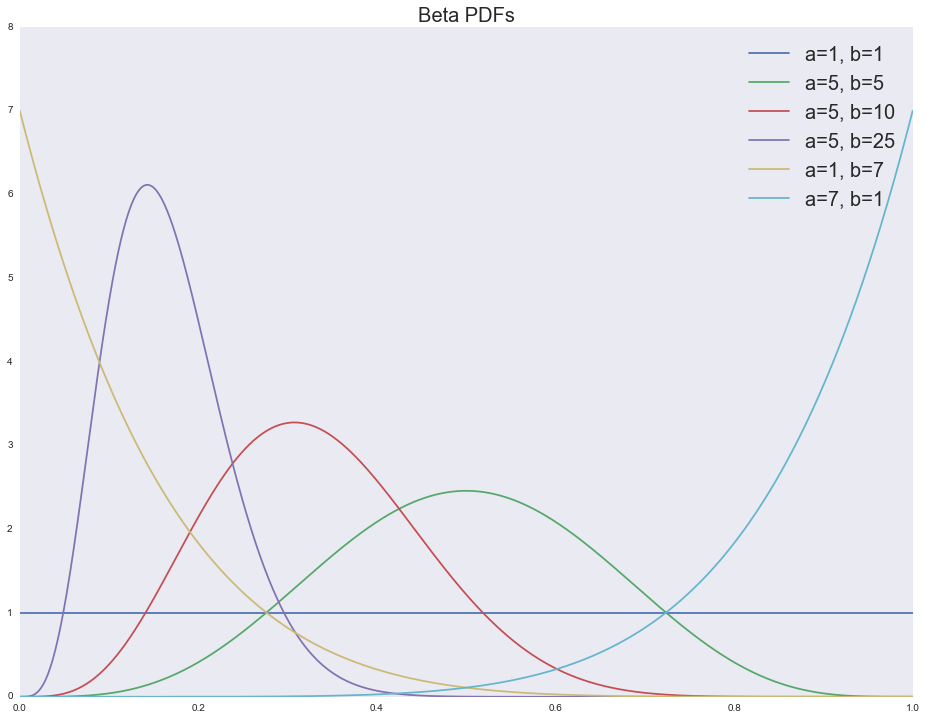

In [14]:
support = np.linspace(0, 1, 1000)
fig, ax = plt.subplots()
for a, b in [(1, 1), (5, 5), (5, 10), (5, 25), (1, 7), (7, 1)]:
    ax.plot(support, stats.beta.pdf(support, a, b), 
            label='a=%i, b=%i' % (a, b))
ax.legend(loc='upper right', prop={'size': 20})
ax.set_title('Beta PDFs', fontsize=20)

Получается, что имея некоторые априорные ожидания об истнном значении конверсии, мы можем использовтаь теорему Байеса и обновлять наши ожидания при поступлении новых данных. А форма априорного распределения после обновления ожиданий остается все тем же бета распределением. Итак у нас есть следующая модель:
$$\large\begin{array}{lcr}
\theta_i &\sim& \text{Beta}\left(\alpha_i, \beta_i\right) \\
y_i &\sim& \text{Bernoulli}\left(\theta_i\right)
\end{array}$$

Тут мы применяем вторую, вполне естественную эвристику: давайте может будем для нового пользователя (новый эксперимент) семплировать руку бандита (вариацию кнопки) не случайно, а пропорционально нашим текущим ожиданиям о полезности этой руки. Но так как у нас байесовская постановка задачи, и мы не храним в явном виде наши оценки полезности, а храним распределение оценок полезности для каждой руки, то и алгоритм семплирования немного изменяется:
0. Для всех бандитов введем два параметра бета распределения и приравняем их к единице $\forall i, \alpha_i = \beta_i = 1$;
- повторяем в течении некоторого времени $t = 1, 2, \ldots$ 
  1. для каждого бандита семплируем $\theta_i \sim \text{Beta}\left(\alpha_i, \beta_i\right)$;
  - выбираем бандита с максимальной наградой $k = \arg\max_{i} \theta_i$
  - используем $k$-ого бандита в текущем эксперименте и получаем награду $y \in \left\{0, 1\right\}$ (показываем ту кнопку текущему пользователю, которая по темущему семплу максимизирует награду);
  - обновляем параметры соответствующего априорного распределения (легко мобифицируется для batch mode, если мы проводим не один, а серию экспериментов): 
    - $\alpha_i := \alpha_i + y$
    - $\beta_i := \beta_i + 1 - y$
    

Семплирование Топпсона является эмпирикой, но для некоторых случаев доказанны теоремы ассимптотической сходимости. В том числе и для Beta-Bernoulli случая, т.е. при $t \rightarrow \infty$ вероятность того, что бандиты с семплированием Томпсона сойдутся к верному решению, равна единице. Но это все теории, на практике нам важно следующее:
- если обозначить вероятность выйгрыша на лучшем бандите за $\theta^*$, то доля трафика портаченного на эту опцию будет пропорциональна $\theta^*$; в процессе обучения, точность оценки будет возрастать и доля трафика, потраченного на нужную опцию, будет расти;
<img src="./../images/abvsb.png" />

- в любой момент времени у нас есть параметры распределения вероятностей выйгрыша на каждой вариации (параметры бета распределения), это позволяет нам применять все те же тесты, что и при классическом тестировании;
- но отметим, что в отличие от тестов, мы не хотим получить ответ в виде статистической значимости разности кликов по разным вариациям, мы, как бизнес, хотим максимизировать CTR, а именно это и делает бандитская модель.

# Эксперимент
Проведем симуляционный эксперимент. Допустим у нас все те же пять вариаций кнопки, но со временем предпочтения пользователей нашего мурлычного сайта плавно меняются. В принципе, динамика уже сразу исключает применение одного A/B/n теста, ну и ладушки.

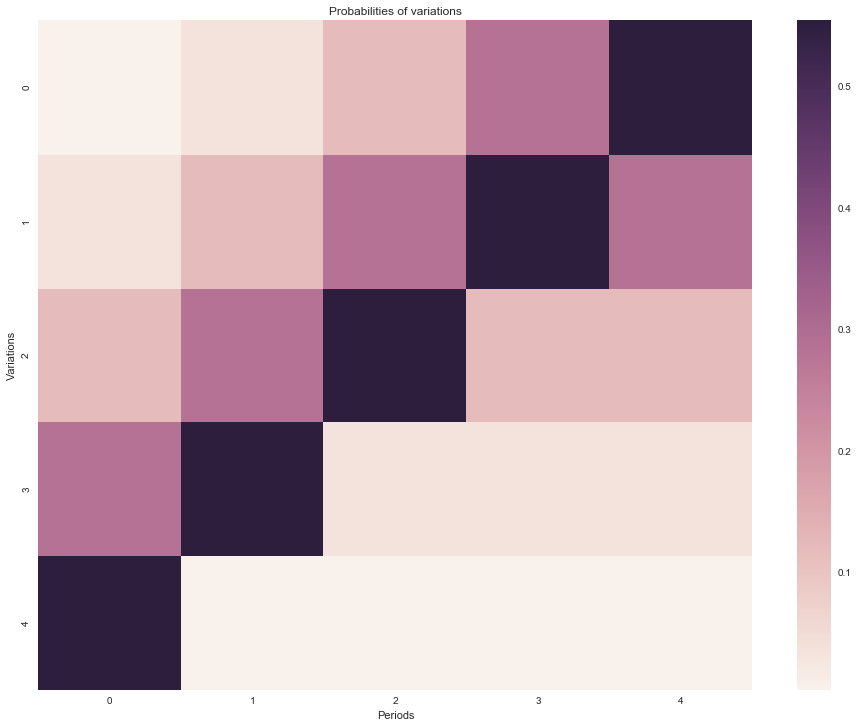

In [15]:
# количество вариаций
n_variations = 5

# сколько раз меняются предпочтения
n_switches = 5

# каждые n_period_len показов кнопки предпочтения пользователей меняются
n_period_len = 2000

# истинные вероятности клика по каждой вариации
# напомню, что длина периода в течении которого тренд не меняется равена n_period_len
p_true_periods = np.array([
        [1, 2, 3, 4, 5],
        [2, 3, 4, 5, 1],
        [3, 4, 5, 2, 1],
        [4, 5, 3, 2, 1],
        [5, 4, 3, 2, 1]], dtype=np.float32).T**3
p_true_periods /= p_true_periods.sum(axis=0)

# отрисуем истинные вероятности
ax = sns.heatmap(p_true_periods)
ax.set(xlabel='Periods', ylabel='Variations', title='Probabilities of variations')
plt.show()

Теперь запустим симуляцию, будем выводить после каждого периода наши оценки вероятности клика по каждой вариации, и убедимся, что к концу каждого периода находится оптимальная вариация. Так же будем следить за тем, сколько трафика из n_period_len отправлено на каждую вариацию. 

В первый период мы четко определяем победителя (самый правый график с явно выраженным пиком). Но вот во втоой период мы уже приходим не с полной неопрдеделенностью (равномерное распределение на параметры), а со статистикой собранной в первый период, и потому мы видем, что существенная доля трафика уходит на старого победителя. К следующим периодам новым лучшим вариациям все труднее выходить в лидеры, обратите внимание, что дисперсия бывших лидеров (ширина пика) меняется очень медленно. Потому часто алгоритм не успевает за заданное количество шагов сойтись. Существует множество способов исправления этой ситуации, самым простым является постепенное выравнивание распределения (приведение к равномерному, т.е. со временем мы теряем уверенность в прошлых оценках - это вполне естесвтенно). 

Winner is 4
4    1953
3      19
2      12
1       8
0       8
dtype: int64


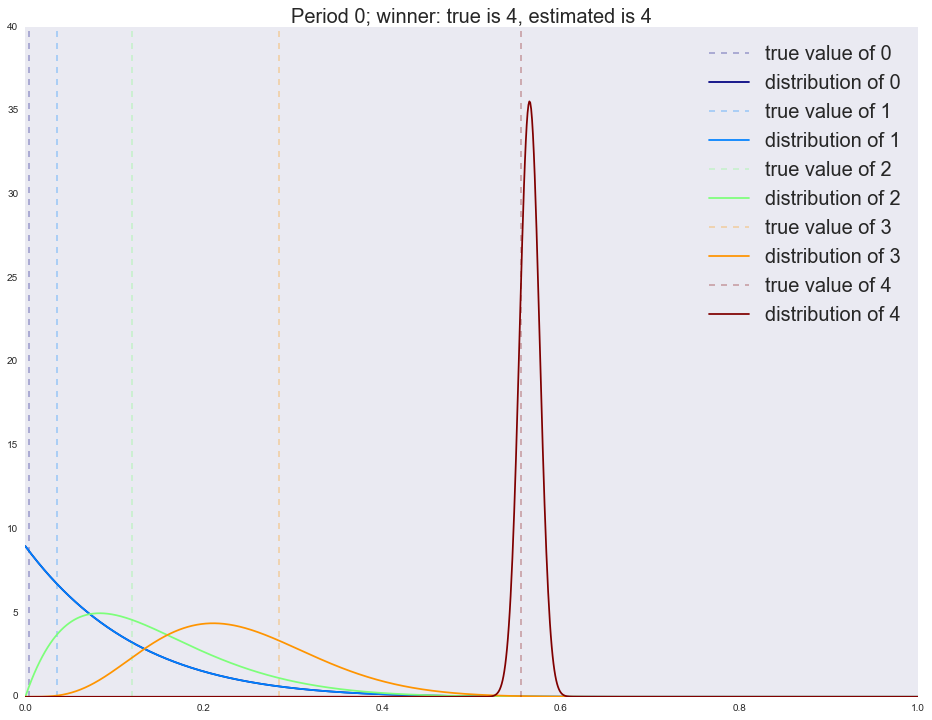

Winner is 4
3    1397
4     593
1       6
2       3
0       1
dtype: int64


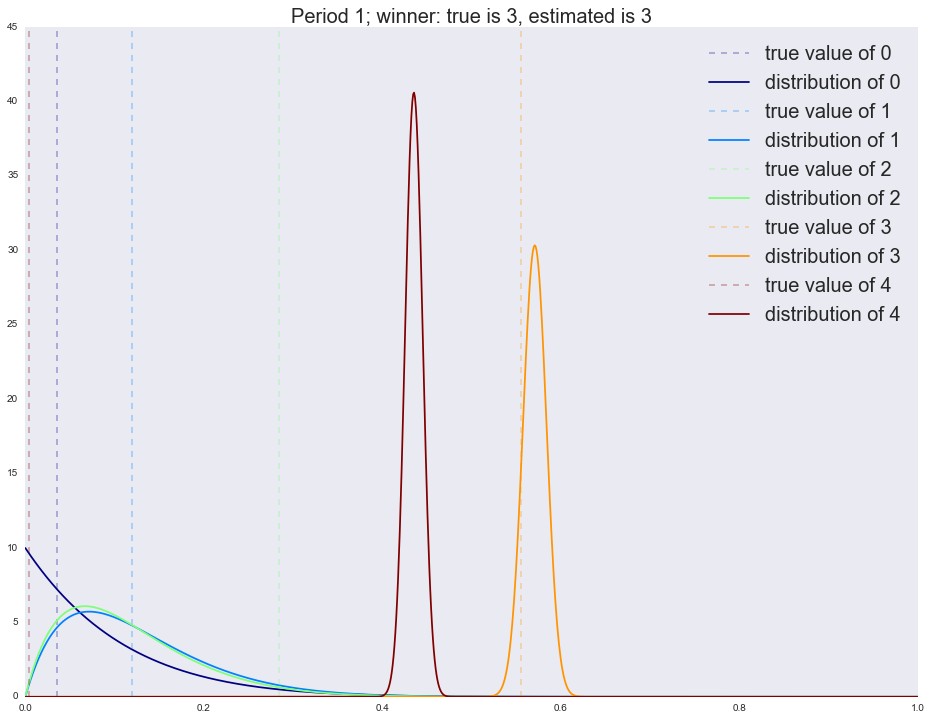

Winner is 4
2    1064
3     675
4     255
1       3
0       3
dtype: int64


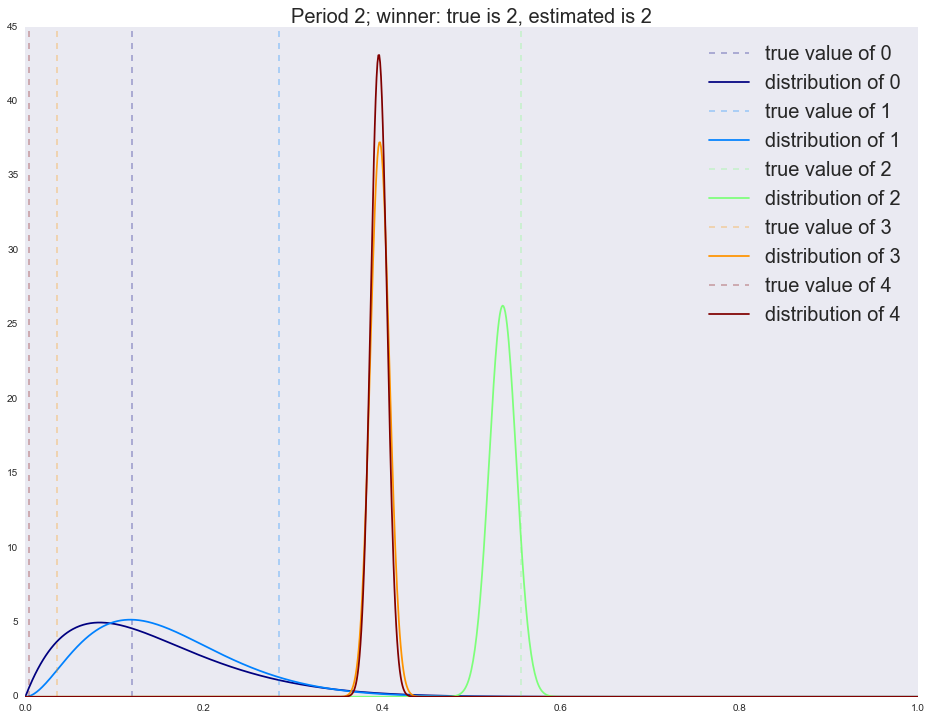

Winner is 4
1    983
2    695
4    144
3    134
0     44
dtype: int64


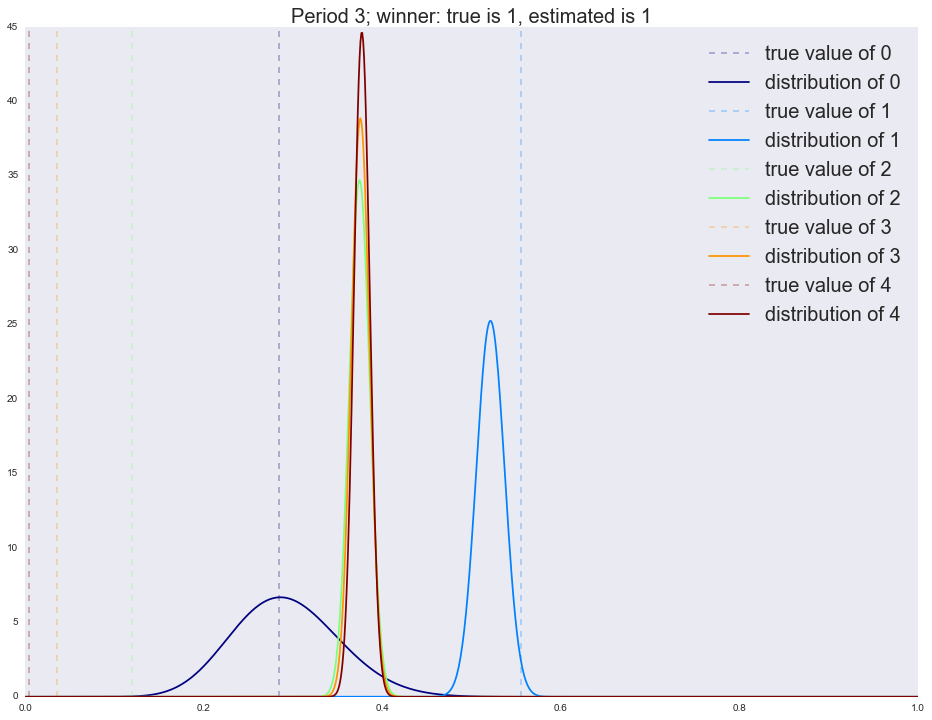

Winner is 4
1    1109
0     888
4       2
2       1
dtype: int64


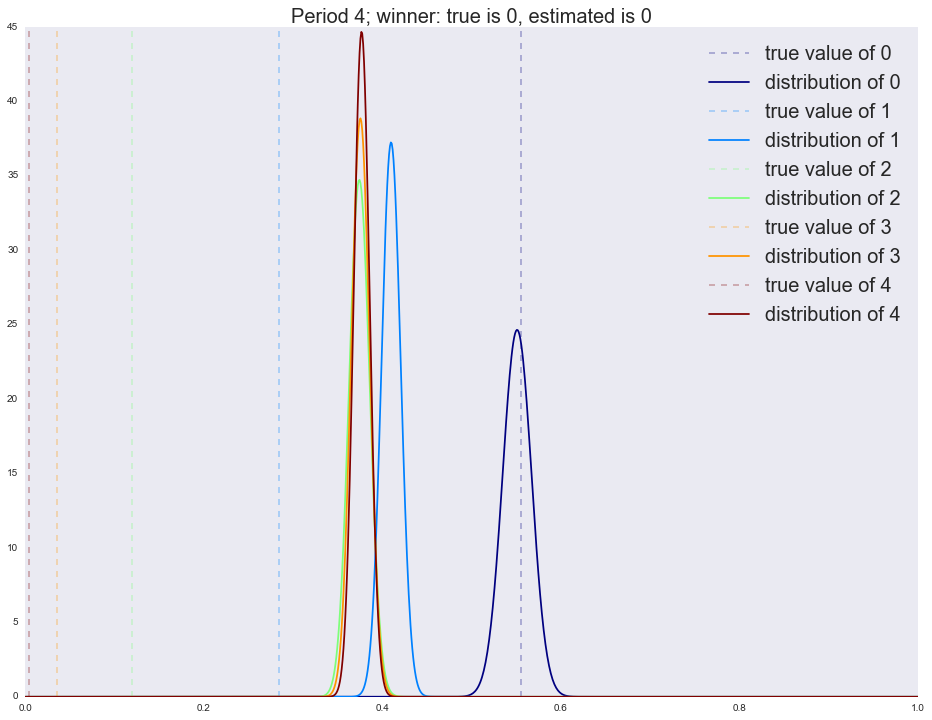

In [16]:
x_support = np.linspace(0, 1, 1000)

alpha = dict([(i, [1]) for i in range(n_variations)])
beta = dict([(i, [1]) for i in range(n_variations)])

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, n_variations)]

actionspp = []

for ix_period in range(p_true_periods.shape[1]):
    p_true = p_true_periods[:, ix_period]
    is_converged = False
    actions = []
    for ix_step in range(n_period_len):
        theta = dict([(i, np.random.beta(alpha[i][-1], beta[i][-1])) 
                      for i in range(n_variations)])
        k, theta_k = sorted(theta.items(), key=lambda t: t[1], reverse=True)[0]
        actions.append(k)
        
        x_k = np.random.binomial(1, p_true[k], size=1)[0]
        
        alpha[k].append(alpha[k][-1] + x_k)
        beta[k].append(beta[k][-1] + 1 - x_k)
    

    expected_reward = dict([(i, alpha[i][-1]/float(alpha[i][-1] + beta[i][-1])) 
                            for i in range(n_variations)])
    estimated_winner = sorted(expected_reward.items(), 
                              key=lambda t: t[1], 
                              reverse=True)[0][0]

    print 'Winner is %i' % i
    actions_loc = pd.Series(actions).value_counts()
    print actions_loc
    actionspp.append(actions_loc.to_dict())
    
    for i in range(n_variations):
        plt.axvline(x=p_true[i], color=colors[i], linestyle='--', 
                    alpha=0.3, label='true value of %i' % i)
        
        plt.plot(x_support, stats.beta.pdf(x_support, alpha[i][-1], beta[i][-1]), 
                 label='distribution of %i' % i, color=colors[i])
    plt.legend(prop={'size': 20})
    plt.title('Period %i; winner: true is %i, estimated is %i' % 
              (ix_period, 
               p_true.argmax(),
               estimated_winner),
              fontsize=20)
    plt.show()

actionspp = dict(enumerate(actionspp))

Отрисуем долю трафика потраченного на каждую вариацию в каждый период.

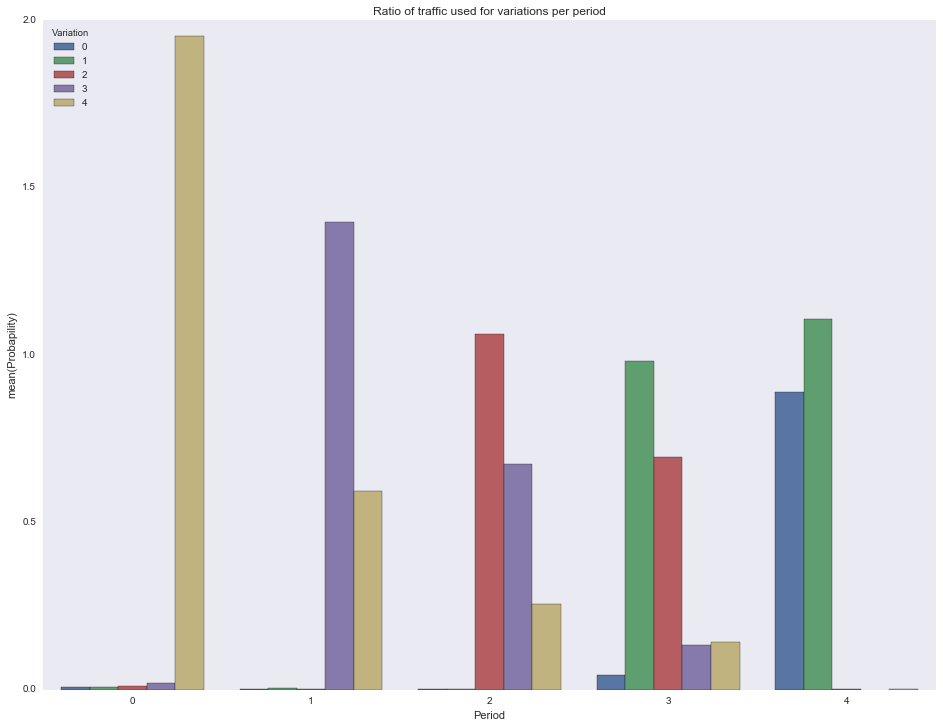

In [17]:
df = []
for pid in actionspp.keys():
    for vid in actionspp[pid].keys():
        df.append({
                'Period': pid,
                'Variation': vid,
                'Probapility': actionspp[pid][vid]/1000.0
            })
df = pd.DataFrame(df)
ax = sns.barplot(x="Period", y="Probapility", hue="Variation", data=df)
ax.set(title="Ratio of traffic used for variations per period")
plt.show()

Ну и под конец нарисуем в динамике изменения наших ожиданий относительно крутости каждой вариации.

In [78]:
n_period_len = 3000

alpha = dict([(i, [1]) for i in range(n_variations)])
beta = dict([(i, [1]) for i in range(n_variations)])
decay = 0.99

plot_step = 25

for f in glob.glob("./../images/mab_gif/*.png"):
    os.remove(f)

img_ix = 0
height = 10 # 15
for ix_period in range(p_true_periods.shape[1]):
    p_true = p_true_periods[:, ix_period]
    is_converged = False
    actions = []
    for ix_step in tqdm_notebook(range(n_period_len)):
        if ix_step % plot_step == 0:
            expected_reward = dict([(i, alpha[i][-1]/float(alpha[i][-1] + beta[i][-1])) 
                                    for i in range(n_variations)])
            estimated_winner = sorted(expected_reward.items(), 
                                      key=lambda t: t[1], 
                                      reverse=True)[0][0]

            fig, ax = plt.subplots()
            ax.set_ylim(0, height)
            ax.set_xlim(0, 1)
            for i in range(n_variations):
                ax.axvline(x=p_true[i], color=colors[i], linestyle='--', 
                           alpha=0.3, label='true value of %i' % i)

                ax.plot(x_support, stats.beta.pdf(x_support, alpha[i][-1], beta[i][-1]), 
                        label='distribution of %i' % i, color=colors[i])
            ax.legend(prop={'size': 20})
            ax.set_title('Period %i, step %i; winner: true is %i, estimated is %i' % 
                         (ix_period, 
                          ix_step,
                          p_true.argmax(),
                          estimated_winner),
                         fontsize=20)
            
            fig.savefig('./../images/mab_gif/%i.png' % img_ix, dpi=80)
            img_ix += 1

            plt.close(fig)
        
        
            theta = dict([(i, np.random.beta(alpha[i][-1], beta[i][-1])) 
                          for i in range(n_variations)])
            k, theta_k = sorted(theta.items(), key=lambda t: t[1], reverse=True)[0]
            actions.append(k)

            x_k = np.random.binomial(1, p_true[k], size=1)[0]

            alpha[k].append(alpha[k][-1] + x_k)
            beta[k].append(beta[k][-1] + 1 - x_k)
            
            if decay > 0:
                for i in range(n_variations):
                    if i == k:
                        continue
                    alpha[i].append(max(1, alpha[i][-1]*decay))
                    beta[i].append(max(1, beta[i][-1]*decay))
        
print img_ix






600


In [71]:
for f in glob.glob("./../images/mab_gif/mab.gif"):
    os.remove(f)
!convert -delay 5 $(for i in $(seq 1 1 600); do echo ./../images/mab_gif/$i.png; done) -loop 0 ./../images/mab_gif/mab.gif
for f in glob.glob("./../images/mab_gif/*.png"):
    os.remove(f)

convert: unable to open image `./../images/mab_gif/600.png': No such file or directory @ error/blob.c/OpenBlob/2705.
convert: unable to open file `./../images/mab_gif/600.png' @ error/png.c/ReadPNGImage/3925.


In [79]:
for f in glob.glob("./../images/mab_gif/mab_decay.gif"):
    os.remove(f)
!convert -delay 5 $(for i in $(seq 1 1 600); do echo ./../images/mab_gif/$i.png; done) -loop 0 ./../images/mab_gif/mab_decay.gif
for f in glob.glob("./../images/mab_gif/*.png"):
    os.remove(f)

convert: unable to open image `./../images/mab_gif/600.png': No such file or directory @ error/blob.c/OpenBlob/2705.
convert: unable to open file `./../images/mab_gif/600.png' @ error/png.c/ReadPNGImage/3925.


<img src="./../images/mab_gif/mab.gif" />

<img src="./../images/mab_gif/mab_decay.gif" />